# Multi-Agent System Designer

In [3]:
with open("./system-design-assistant-prompt.md") as f:
    writer_prompt = f.read()

with open("./requirement_analyzer_prompt.txt") as f:
    analyzer_prompt = f.read()

with open("./diagram_drawer_prompt.txt") as f:
    drawer_prompt = f.read()

In [52]:
import functools
import orjson

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities import GoogleSearchAPIWrapper
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import END, MessageGraph
from langgraph.prebuilt.tool_node import ToolNode
from langchain_core.tools import Tool
from langchain_core.messages import AIMessage

# Define the function that determines whether to continue or not
# Either agent can decide to end

from langchain_core.pydantic_v1 import BaseModel

import operator
from typing import Annotated, Sequence, TypedDict, List, Optional,Literal

from langchain_openai import ChatOpenAI
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)

from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph


def create_agent(llm, prompt: str, tools: Optional[List[Tool]] = None, options=["WRITE DOC", "ANALYZE REQUIREMENT", "FINAL ANSWER"]):
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                prompt
                + " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    # prompt = prompt.partial(options=", ".join([opt for opt in options]))
    if tools is not None:
        prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
        return prompt | llm.bind_tools(tools)
    else:
        return prompt | llm


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str


def router(state) -> Literal["call_tool", "end", "continue"]:
    messages = state["messages"]
    last_message = messages[-1]

    # if hasattr(last_message, 'tool_calls') and not last_message.tool_calls:
    #     return "end"

    # if isinstance(last_message, AIMessage) and last_message.tool_calls:
    #     return "call_tool"

    if (
        last_message.content.strip().upper() == "FINALIZE"
        or last_message.content.strip().upper() == "WRITE_DOC"
    ):
        return "document_writer"

    if last_message.content.strip().upper() == "FINAL ANSWER":
        return "__end__"

    return "continue"


def limit_message_history(messages, max_length=5):
    """Limit the message history to the most recent max_length messages."""
    if len(messages) > max_length:
        return messages[-max_length:]
    return messages


def agent_node(state, agent, name, max_history_length=50, max_context_length=16385):
    # available_tokens = calculate_available_tokens(state["messages"], max_context_length)
    state["messages"] = limit_message_history(state["messages"])
    # Invoke the agent with limited tokens
    result = agent.invoke(state)

    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)

    messages = state["messages"] + [result]
    messages = limit_message_history(messages, max_history_length)

    return {
        "messages": messages,
        "sender": name,
    }


def user_input_node(state, max_history_length=10):
    user_input = input("Please provide more details or type 'FINALIZE' to proceed: ")
    messages = state["messages"] + [HumanMessage(content=user_input)]

    # Limit the message history
    messages = limit_message_history(messages, max_history_length)

    return {
        "messages": messages,
        "sender": "human",
    }


def calculate_available_tokens(messages, max_context_length=16385, reserved_tokens=100):
    message_token_count = sum(len(m.content.split()) for m in messages)
    return max(0, max_context_length - message_token_count - reserved_tokens)


tavily_tool = TavilySearchResults(max_results=5)
# Define a new graph
workflow = StateGraph(AgentState)


# tools = [tavily_tool]
tools = []
llm = ChatOpenAI(model="gpt-3.5-turbo-16k", max_tokens=None)
requirement_analyzer = create_agent(llm, analyzer_prompt, None)
analyzer_node = functools.partial(
    agent_node, agent=requirement_analyzer, name="Requirement_Analyzer"
)
doc_writer = create_agent(llm, writer_prompt, None)
writer_node = functools.partial(
    agent_node, agent=doc_writer, name="Doc_Writer"
)
tool_node = ToolNode(tools)
workflow.add_node("requirement_analyzer", analyzer_node)
workflow.add_node("document_writer", writer_node)
workflow.add_node("call_tool", tool_node)
workflow.add_node("user_input", user_input_node)

# Conditional agent -> action OR agent -> END
# Add conditional edges to the workflow
workflow.add_conditional_edges(
    "requirement_analyzer",
    router,
    {
        "ask_human": "user_input",
        "continue": "user_input",
        "call_tool": "call_tool",
        "document_writer": "document_writer",
        "FINALIZE": "document_writer",
    },
)
workflow.add_conditional_edges(
    "document_writer",
    router,
    {
        "continue": "user_input",
        "call_tool": "call_tool",
        "revise": "document_writer",
        "requirement_analyzer": "requirement_analyzer",
        "__end__": END,
    },
)
workflow.add_conditional_edges(
    "user_input",
    router,
    {
        "requirement_analyzer": "requirement_analyzer",
        "document_writer": "document_writer",
        "continue": "requirement_analyzer",
    },
)
# workflow.add_conditional_edges(
#     "call_tool",
#     lambda x: x["sender"],
#     {
#         "requirement_analyzer": "requirement_analyzer",
#         "document_writer": "document_writer",
#     },
# )
workflow.set_entry_point("user_input")
memory = SqliteSaver.from_conn_string(":memory:")  # Here we only save in-memory

# Setting the interrupt means that any time an action is called, the machine will stop
app = workflow.compile(checkpointer=memory)

In [27]:
ChatOpenAI??

Init signature:
ChatOpenAI(
    *,
    name: Optional[str] = None,
    cache: ForwardRef('Union[BaseCache, bool, None]') = None,
    verbose: bool = None,
    callbacks: ForwardRef('Callbacks') = None,
    tags: Optional[List[str]] = None,
    metadata: Optional[Dict[str, Any]] = None,
    custom_get_token_ids: Optional[Callable[[str], List[int]]] = None,
    callback_manager: Optional[langchain_core.callbacks.base.BaseCallbackManager] = None,
    client: Any = None,
    async_client: Any = None,
    model: str = 'gpt-3.5-turbo',
    temperature: float = 0.7,
    model_kwargs: Dict[str, Any] = None,
    api_key: Optional[pydantic.v1.types.SecretStr] = None,
    base_url: Optional[str] = None,
    organization: Optional[str] = None,
    openai_proxy: Optional[str] = None,
    timeout: Union[float, Tuple[float, float], Any, NoneType] = None,
    max_retries: int = 2,
    streaming: bool = False,
    n: int = 1,
    max_tokens: Optional[int] = None,
    tiktoken_model_name: Optional[str] 

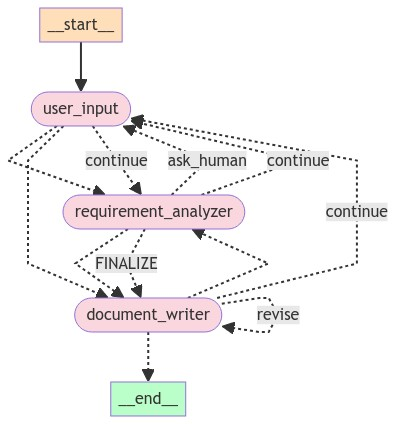

In [38]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [53]:
import uuid


config = {
    "recursion_limit": 150,
    "configurable": {
        "thread_id": str(uuid.uuid4()),  # Replace with actual thread_id value
        "thread_ts": str(uuid.uuid4()),  # Replace with actual thread_ts value
    },
}

# while True:
#     user_input = input("User (type 'FINALIZE REQUIREMENTS' to proceed, 'q/Q to quit): ")
#     if user_input in {"q", "Q"}:
#         print("AI: Byebye")
#         break

state = {
    "messages": [],
    "system_message": "Your job is to assist users writing system design documents.",
}


for s in app.stream(state, config):
    print(s)
    if "__end__" not in s:
        role = list(s.keys())[0]
        messages = s[role].get("messages")

        print(f"{role}:\n{messages[-1].content}\n")

        if messages:
            last_message = messages[-1]
            if "q" == last_message.content or "Q" == last_message.content:
                break
    else:
        print("Done!")
        break

{'user_input': {'messages': [HumanMessage(content='Please help me write a system design document for a stock ranking system. Main Objectives: 1. Help investors select stocks based on the ranked factor values  Requirements: 1. Users receive a sorted table of stocks based on the factor value 2. Users can select the date of the factor data  Constraints: 1. Data must be point-in-time 2. The stock ranking system receives data from another data ingestion system  Specific Requirement: 1. Data must be point-in-time 2. Output should be sorted by factor value. If there are multiple factors, the result must be based on the weighted sum of factor values.  If you are not sure about the details of each section, feel free to ask.')], 'sender': 'human'}}
user_input:
Please help me write a system design document for a stock ranking system. Main Objectives: 1. Help investors select stocks based on the ranked factor values  Requirements: 1. Users receive a sorted table of stocks based on the factor value